In [ ]:
%pip install pandas
%pip install pydmd
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install keras_tuner
%pip install keras
%pip install numpy
%pip install optuna

In [ ]:
import sys, platform

base_path = '/home/yurid/git/tcc'

if platform.system() == 'Darwin':
    base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
    
sys.path.insert(0, base_path)

In [ ]:
from math import sqrt

import keras
import numpy as np
import pandas as pd
import optuna
from keras import layers
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from src.dataframe import show_error_metrics

In [ ]:
city = 'juiz de fora'

In [ ]:

def windowing(dataframe, predict_column, step_back, step_front) -> (np.array, np.array):
    dataset = dataframe.values
    dataset_pred = dataframe[predict_column].values

    x, y = [], []
    for i in range(len(dataset) - step_back - step_front):
        j = (i + step_back)
        x.append(dataset[i:j])
        y.append(dataset_pred[j:(j+step_front)])

    return np.array(x), np.array(y)



def split_data(x, y, length, ratio=0.8):
    train_size = int(length * 0.9)
    _train_x, _train_y = x[0:train_size], y[0:train_size].reshape(y[0:train_size].shape[0],)
    _test_x, _test_y = x[train_size:], y[train_size:].reshape(y[train_size:].shape[0],)
    return _train_x, _train_y, _test_x, _test_y


def fill_df(dataframe, filler):
    data = {}
    for column in dataframe.columns:
        data[column] = filler(dataframe[column])
    return pd.DataFrame(data=data, index=dataframe.index.values)


def interpolate_filler(data):
    return data.interpolate(method='linear', limit_direction='backward')


class Scaler:
    scales: {}
    df: DataFrame
    df_scaled: DataFrame
    scaled: bool

    def __init__(self, df: DataFrame, feature_range=(0, 1)):
        self.df = df.copy()
        self.scales = {}
        for c in df.columns:
            self.scales[c] = MinMaxScaler(feature_range=feature_range)
        self.scaled = False

    def get_dataframe_scaled(self):
        if self.scaled:
            return self.df_scaled
        self.scaled = True
        self.df_scaled = self.df.copy()
        for c in self.df.columns:
            self.df_scaled[c] = self.scales[c] \
                .fit_transform(self.df_scaled[c].values.reshape(-1, 1))
        return self.df_scaled


In [ ]:
df_temp = pd.read_csv(
    f'{base_path}/data/daily_muriae.csv',
    sep=',',
    parse_dates=['Timestamp'],
    index_col=['Timestamp'])

init_index = lambda _df: _df[_df.RADIATION != 0].index[0]

df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
    .resample('D') \
    .agg({'RADIATION': np.sum, 'TEMP': np.mean, 'HUMIDITY_h': np.mean})

df = df.loc[df.index >= init_index(df)].replace(0, np.nan)
print('Dados faltantes:', df.isna().sum())


df = fill_df(df, interpolate_filler)
print('Dados faltantes:', df.isna().sum())


scaler = Scaler(df)
df = scaler.get_dataframe_scaled()

df

In [ ]:
pyplot.figure(figsize=(18,8))

pyplot.plot(df['RADIATION'], color='blue', label='Radiation')

pyplot.show()

In [ ]:
X, Y = windowing(df, predict_column='RADIATION', step_back=5, step_front=1)
x_train, y_train, x_test, y_test = split_data(X, Y, length=len(df), ratio=0.9)

In [ ]:
print('x', x_train[0])
print('y', y_train[0])

In [ ]:
print(x_train.shape)
print(y_train.shape)

In [ ]:
def objective(trial):
    n_hidden = trial.suggest_categorical(f"hidden_layers", [0, 1, 2, 3, 5])

    model = keras.Sequential()
    model.add(Dense(units=1, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(
        units=trial.suggest_categorical("lstm_01_unit", [10, 32, 64, 128, 200, 300]),
        return_sequences = n_hidden > 0
        ))
    
    if (trial.suggest_int("enable_dropout_01", 0, 1) == 1):
        model.add(Dropout(
            rate=trial.suggest_categorical("dropout_01_rs", [0, 0.1, 0.25])
        ))

    for i in range(n_hidden):
        model.add(LSTM(
            units=trial.suggest_categorical(f"lstm_{i}_unit", [10, 32, 64, 128, 200, 300]),
            return_sequences = i != (n_hidden-1),
            dropout=trial.suggest_categorical(f"lstm_{i}_drp", [0, 0.1, 0.25])
        ))

    model.add(layers.Dense(1, 
        activation=trial.suggest_categorical("output_activation", ['relu', 'softmax', 'sigmoid'])
    ))
    
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    
    model.compile(
        loss="mse",
        optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    print('model output_shape', model.output_shape)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    model.fit(
        x_train,
        y_train,
        validation_split=trial.suggest_categorical("validation_split", [0.1, 0.2, 0.3]),
        shuffle=True,
        batch_size=trial.suggest_categorical("batch_size", [10, 16, 32, 64]),
        epochs=100,
        verbose=0,
        callbacks=[es]
    )

    predict = model.predict(x_test)
    y = y_test.reshape(-1,1)
    
    print('Max Y', max(y_test))
    print('Min Y', min(y_test))
    print('Max Pred', max(predict))
    print('Min Pred', min(predict))
    
    mae = mean_absolute_error(y, predict)
    print('MAE SCORE:', mae)
    return mae

In [ ]:
n_trials = 200
run_study = False

study = optuna.create_study(
    direction='minimize',
    storage='sqlite:///radiation-forecast.db',
    study_name=f'{city}_interpolate_lstm',
    load_if_exists=True
)

if len(study.trials) < n_trials and run_study:
    study.optimize(
        objective, 
        n_trials=n_trials, 
        gc_after_trial=True,
        n_jobs=8
    )   

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
n_trials = 200
run_study = False

study = optuna.create_study(
    direction='minimize',
    storage='sqlite:///radiation-forecast.db',
    study_name=f'{city}_interpolate_lstm',
    load_if_exists=True
)

if len(study.trials) < n_trials and run_study:
    study.optimize(
        objective, 
        n_trials=n_trials, 
        gc_after_trial=True,
        n_jobs=8
    )   

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

model output_shape (None, 1)
Epoch 1/100
303/303 [==============================] - 13s 29ms/step - loss: 0.0448 - accuracy: 4.1382e-04 - val_loss: 0.0394 - val_accuracy: 0.0000e+00
Epoch 2/100
303/303 [==============================] - 7s 23ms/step - loss: 0.0442 - accuracy: 2.0691e-04 - val_loss: 0.0369 - val_accuracy: 0.0000e+00
Epoch 3/100
303/303 [==============================] - 7s 24ms/step - loss: 0.0402 - accuracy: 4.1382e-04 - val_loss: 0.0386 - val_accuracy: 0.0000e+00
Epoch 4/100
303/303 [==============================] - 7s 24ms/step - loss: 0.0386 - accuracy: 4.1382e-04 - val_loss: 0.0337 - val_accuracy: 0.0000e+00
Epoch 5/100
303/303 [==============================] - 7s 23ms/step - loss: 0.0372 - accuracy: 4.1382e-04 - val_loss: 0.0330 - val_accuracy: 0.0000e+00
Epoch 6/100
303/303 [==============================] - 7s 23ms/step - loss: 0.0363 - accuracy: 4.1382e-04 - val_loss: 0.0326 - val_accuracy: 0.0000e+00
Epoch 7/100
303/303 [==============================] - 7s 

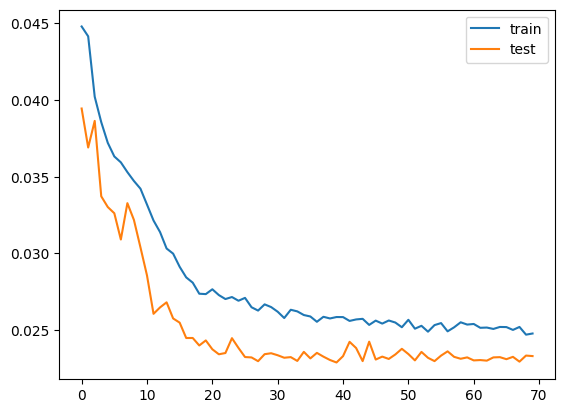

19/19 [==============================] - 1s 9ms/step
Test R2: 0.412
Test MSE: 0.021
Test RMSE: 0.146
Test MAE: 0.111
Test MAPE: 0.407


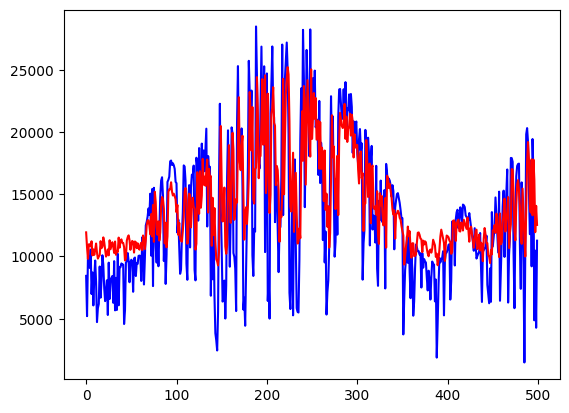

In [16]:
n_hidden = 3

model = keras.Sequential()
model.add(Dense(units=1, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(
    units=10,
    return_sequences = n_hidden > 0
    ))


model.add(Dropout(
    rate=0.25
))


model.add(LSTM(
    units=10,
    return_sequences = True,
    dropout=0.1
))

model.add(LSTM(
    units=10,
    return_sequences = True,
    dropout=0.25
))

model.add(LSTM(
    units=200,
    return_sequences = False,
    dropout=0
))

# model.add(LSTM(
#     units=64,
#     return_sequences = True,
#     dropout=0
# ))

# model.add(LSTM(
#     units=128,
#     return_sequences = False,
#     dropout=0
# ))

model.add(layers.Dense(1, 
    activation='sigmoid'
))

learning_rate = 0.0008210455305492992

model.compile(
    loss="mse",
    optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

print('model output_shape', model.output_shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
history = model.fit(
    x_train,
    y_train,
    validation_split=0.1,
    shuffle=True,
    batch_size=16,
    epochs=100,
    verbose=1,
    callbacks=[es]
)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



predict = model.predict(x_test)
show_error_metrics(y_test.reshape(-1,1), predict)

real = scaler.scales['RADIATION'].inverse_transform(y_test.reshape(-1,1))
predict = scaler.scales['RADIATION'].inverse_transform(predict)

range_plot = 500
pyplot.plot(real[0:range_plot], color='blue', label='real')
pyplot.plot(predict[0:range_plot], color='red', label='incompleto')

pyplot.show()